In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Code for calculating DTW distance

In [17]:
def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [3]:
s1 = [1,3,4,9,8,2,1,5,7,3]
s2 = [1,6,2,3,0,9,4,3,6,3]

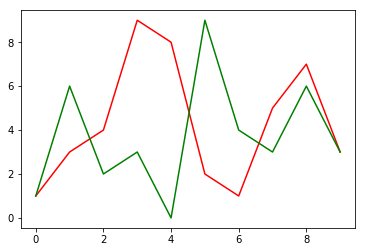

In [4]:
plt.plot(range(len(s1)), s1, 'r-')
plt.plot(range(len(s2)), s2, 'g-')
plt.show()

In [6]:
DTWDistance(s1, s2)

6.082762530298219

## Work on Answerer time series

In [2]:
with open('./data/processed/topans.pkl','rb') as picklefile:
    topans = pickle.load(picklefile)

In [3]:
topans.head()

,id,about_me_length,location,up_votes,down_votes,website_url,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,Active,creation_year,creation_month
1274,6632595,0.0,,3.0,0.0,,0,0,1,0,13,3,1,0,1,2016,7
5951,5619724,217.0,Australia,87.0,3.0,,2,1,0,0,0,3,7,13,1,2015,11
5977,4315695,0.0,India,4.0,9.0,,0,0,0,0,0,0,0,0,1,2014,12
5979,8932080,354.0,France,61.0,10.0,https://www.awesomeprods.fr,0,0,0,0,0,0,0,0,1,2017,11
5993,1175029,334.0,,23.0,3.0,,11,7,7,1,5,3,5,5,1,2012,1


In [9]:
topans.set_index('id', inplace=True)
cols_to_drop = ['about_me_length', 'location', 'up_votes', 'down_votes', 'website_url', 'creation_year', 'creation_month']
topans.drop(cols_to_drop, axis=1, inplace=True)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(topans.iloc[:,:-1], topans['Active'], test_size=0.2, random_state=4444, stratify=topans['Active'])

In [11]:
train_ts, test_ts = train_test_split(topans.values, test_size=0.2, random_state=4444, stratify=topans['Active'])

### Cross-Validation

In [15]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return sqrt(LB_sum)

In [16]:
def knnDTW(train,test, w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [13]:
kf = KFold(n=train_ts.shape[0], n_folds=5, shuffle=True)
FP = []
FN = []
TP = []
TN = []

for train, test in kf:
    train_cv = train_ts[train]
    test_cv = train_ts[test]
    

In [19]:
knnDTW(train_cv, test_cv, 4)

'             precision    recall  f1-score   support\n\n          0       0.40      0.41      0.40       382\n          1       0.90      0.89      0.90      2246\n\navg / total       0.83      0.82      0.82      2628\n'